In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
plt.rcParams['figure.figsize'] = (10,10)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import seaborn as sns

In [5]:
from training_utils import iterative_pruning
from training_utils import initializer

Set Seeds

In [6]:
import tensorflow as tf

In [7]:
seed = 7531
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
import matplotlib

In [9]:
np.where(np.linspace(-0.3,0.3,1001) == 0)

(array([500], dtype=int64),)

In [10]:
gnbu_b = plt.get_cmap("GnBu")(np.linspace(-0.3,0.3,1001))
gnbu_b[500,:] = np.array([0.,0.,0.,1.])
cmap = matplotlib.colors.ListedColormap(gnbu_b)

### Tensorflow

In [11]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers

Masking: https://stackoverflow.com/questions/38278965/selectively-zero-weights-in-tensorflow

In [12]:
import tensorflow_datasets as tfds

In [13]:
(ds_train_mnist, ds_test_mnist), ds_info_mnist = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [14]:
ds_train_mnist_sm, ds_info_mnist_sm = tfds.load(
    'mnist',
    split=tfds.Split.TRAIN.subsplit(tfds.percent[:80]),
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

In [15]:
(ds_train_fash, ds_test_fash), ds_info_fash = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [16]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    #print(image.shape)
    print(tf.reshape(image, [tf.shape(image)[0]*tf.shape(image)[1]]).shape)
    print(tf.one_hot(label,10).shape)
    return tf.cast(tf.reshape(image, [tf.shape(image)[0]*tf.shape(image)[1]]), tf.float32) / 255., tf.one_hot(label,10)

def prep_data(ds, ds_info):
    ds = ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()
    ds = ds.shuffle(ds_info.splits['train'].num_examples)
    ds = ds.batch(128)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds
#ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#ds_train = ds_train.cache()
#ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
#ds_train = ds_train.batch(128)
#ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

#ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#ds_test = ds_test.cache()
#ds_test = ds_test.shuffle(ds_info.splits['train'].num_examples)
#ds_test = ds_test.batch(128)
#ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [17]:
ds_train_mnist = prep_data(ds_train_mnist, ds_info_mnist)
ds_test_mnist = prep_data(ds_test_mnist, ds_info_mnist)

ds_train_fash = prep_data(ds_train_fash, ds_info_fash)
ds_test_fash = prep_data(ds_test_fash, ds_info_fash)

ds_train_mnist_sm = prep_data(ds_train_mnist_sm, ds_info_mnist_sm)

(784,)
(10,)
(784,)
(10,)
(784,)
(10,)
(784,)
(10,)
(784,)
(10,)


In [18]:
from custom_nn import Linear, FCN, FCN_Mask

In [19]:
def get_input_dim(ds):
    return iter(ds).next()[0].shape[1]
def get_batch_size(ds):
    return iter(ds).next()[0].shape[0]

In [20]:
input_dim = get_input_dim(ds_train_mnist)
batch_size = get_batch_size(ds_train_mnist)

In [21]:
input_dim

784

In [27]:
def just_eval(model, ds_test):
    eval_acc = tf.keras.metrics.CategoricalAccuracy()
    eval_loss_mean = tf.keras.metrics.Mean()
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    for x_batch_test, y_batch_test in ds_test:
        eval_pred = model(x_batch_test)
        eval_loss = loss_fn(y_batch_test, eval_pred)

        eval_loss_mean(eval_loss)
        eval_acc(y_batch_test, eval_pred)

    print(f"Evaluation Loss: {eval_loss_mean.result().numpy()}")
    print(f"Evaluation Accuracy: {eval_acc.result().numpy()}")

### Baseline

In [93]:
NO_LAYERS = 3
LAYER_SHAPES = np.array([[input_dim, 300], [300,100], [100,10]])
fcn = FCN(input_dim, layer_shapes=LAYER_SHAPES)

In [94]:
init = initializer()

initializer


In [95]:
MU=0
MU_BI = [-0.13, 0.13]
SIGMA=-1 #0.1 IF SIGMA == -1 --> glorot normal
SIGMA_BI = [-SIGMA, SIGMA]
fcn, initial_weights = init.set_weights_man(fcn, mode="signed_constant", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=False)

In [96]:
def just_train(model, ds_train, epochs=6):
    optimizer = tf.keras.optimizers.Adam(1.2e-3) #tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    loss_metric = tf.keras.metrics.Mean()
    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    
    loss_history = []
    acc_history = []
    
    for epoch in range(epochs):
    
        #print(f"Start of epoch {epoch}")

        # Iterate over the batches of the dataset.
        for step, (x_batch_train,y_batch_train) in enumerate(ds_train):
            with tf.GradientTape() as tape:
                predicted = model(x_batch_train)
                # Compute reconstruction loss
                loss = loss_fn(y_batch_train, predicted)


            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            loss_metric(loss)
            acc_metric(y_batch_train,predicted)
        
        loss_history.append(loss_metric.result().numpy())
        acc_history.append(acc_metric.result().numpy())

        print(f"End of Epoch: {epoch+1}: Accuracy = {acc_metric.result().numpy():.6f} --- Mean Loss = {loss_metric.result().numpy():.6f}")
    
    return loss_history #model, 

In [97]:
loss_history = just_train(fcn, ds_train_mnist, epochs=60)

End of Epoch: 1: Accuracy = 0.869650 --- Mean Loss = 0.443238
End of Epoch: 2: Accuracy = 0.909992 --- Mean Loss = 0.305115
End of Epoch: 3: Accuracy = 0.928922 --- Mean Loss = 0.239190
End of Epoch: 4: Accuracy = 0.940721 --- Mean Loss = 0.198878
End of Epoch: 5: Accuracy = 0.948947 --- Mean Loss = 0.170772
End of Epoch: 6: Accuracy = 0.955081 --- Mean Loss = 0.149961
End of Epoch: 7: Accuracy = 0.959855 --- Mean Loss = 0.133694
End of Epoch: 8: Accuracy = 0.963729 --- Mean Loss = 0.120582
End of Epoch: 9: Accuracy = 0.966991 --- Mean Loss = 0.109541
End of Epoch: 10: Accuracy = 0.969708 --- Mean Loss = 0.100453
End of Epoch: 11: Accuracy = 0.972018 --- Mean Loss = 0.092730
End of Epoch: 12: Accuracy = 0.973986 --- Mean Loss = 0.086144
End of Epoch: 13: Accuracy = 0.975672 --- Mean Loss = 0.080522
End of Epoch: 14: Accuracy = 0.977155 --- Mean Loss = 0.075543
End of Epoch: 15: Accuracy = 0.978380 --- Mean Loss = 0.071400
End of Epoch: 16: Accuracy = 0.979549 --- Mean Loss = 0.067516
E

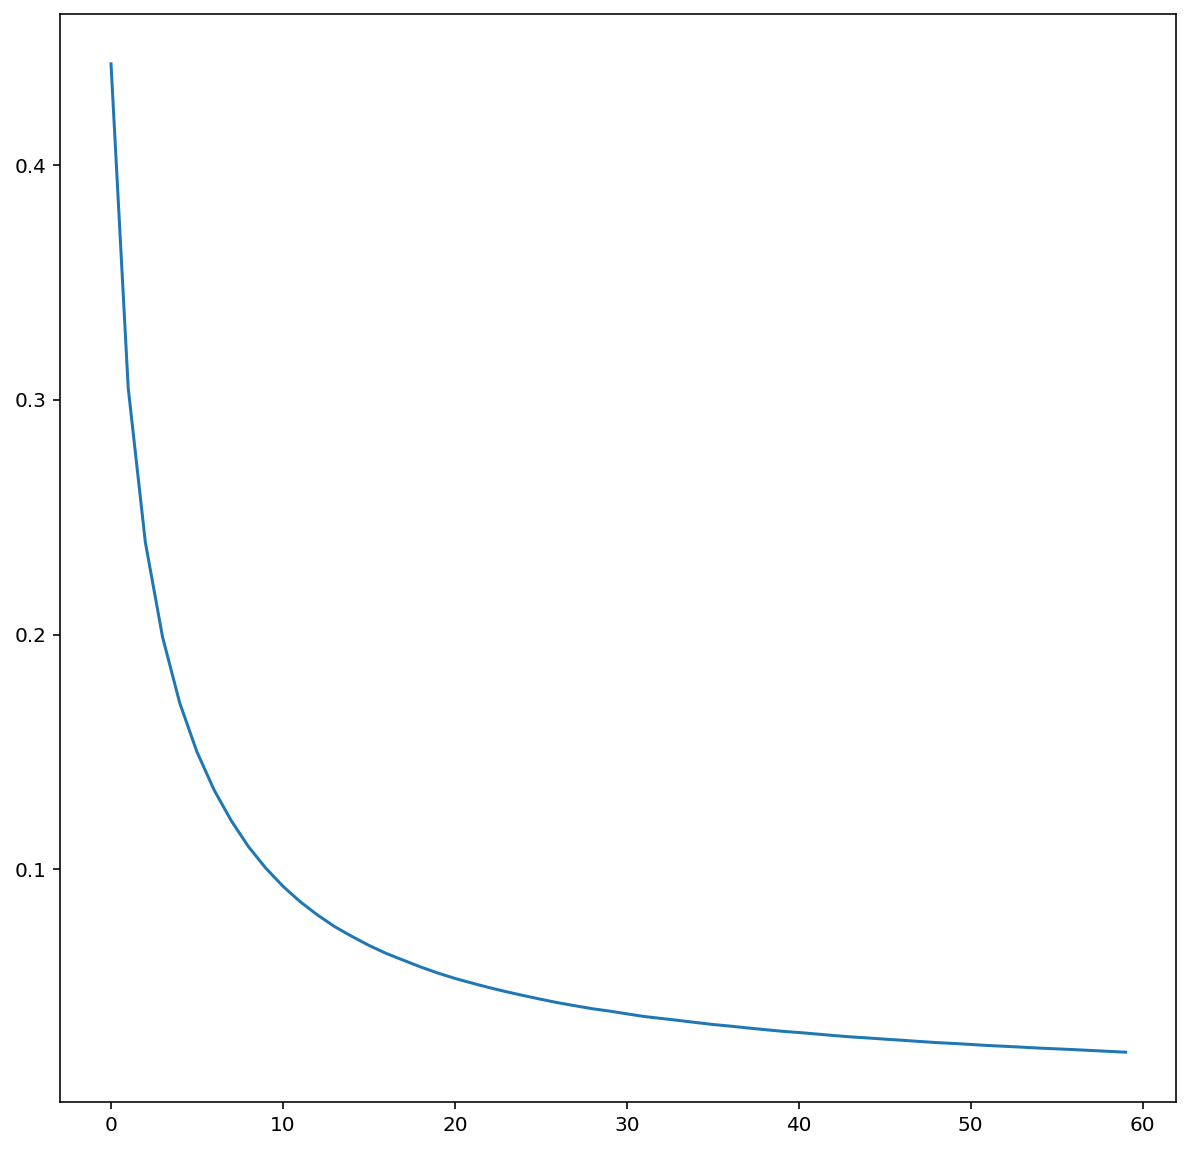

In [98]:
plt.plot(loss_history)

In [99]:
just_eval(fcn, ds_test_mnist)

Evaluation Loss: 0.12451748549938202
Evaluation Accuracy: 0.9833999872207642


### Supermask

In [148]:
from custom_nn import Linear, FCN, FCN_Mask

In [149]:
NO_LAYERS = 3
LAYER_SHAPES = np.array([[input_dim, 300], [300,100], [100,10]])
fcn_mask = FCN_Mask(input_dim, layer_shapes=LAYER_SHAPES)

In [150]:
fcn_mask.layers[0].get_weights()[0].shape

(784, 300)

In [139]:
for i,layer in enumerate(fcn_mask.layers):
    layer.set_normal_weights(fcn.layers[i].get_weights()[0])

In [151]:
init = initializer()

initializer


In [168]:
test = 4*np.random.randn(1000000)

In [169]:
test_pos = test[np.where(test > 0)]

(array([1.92929e+05, 1.50773e+05, 9.12880e+04, 4.32630e+04, 1.61750e+04,
        4.59000e+03, 1.01200e+03, 2.03000e+02, 2.00000e+01, 4.00000e+00]),
 array([7.12149869e-06, 2.01465962e+00, 4.02931212e+00, 6.04396463e+00,
        8.05861713e+00, 1.00732696e+01, 1.20879221e+01, 1.41025746e+01,
        1.61172271e+01, 1.81318796e+01, 2.01465321e+01]),
 <a list of 10 Patch objects>)

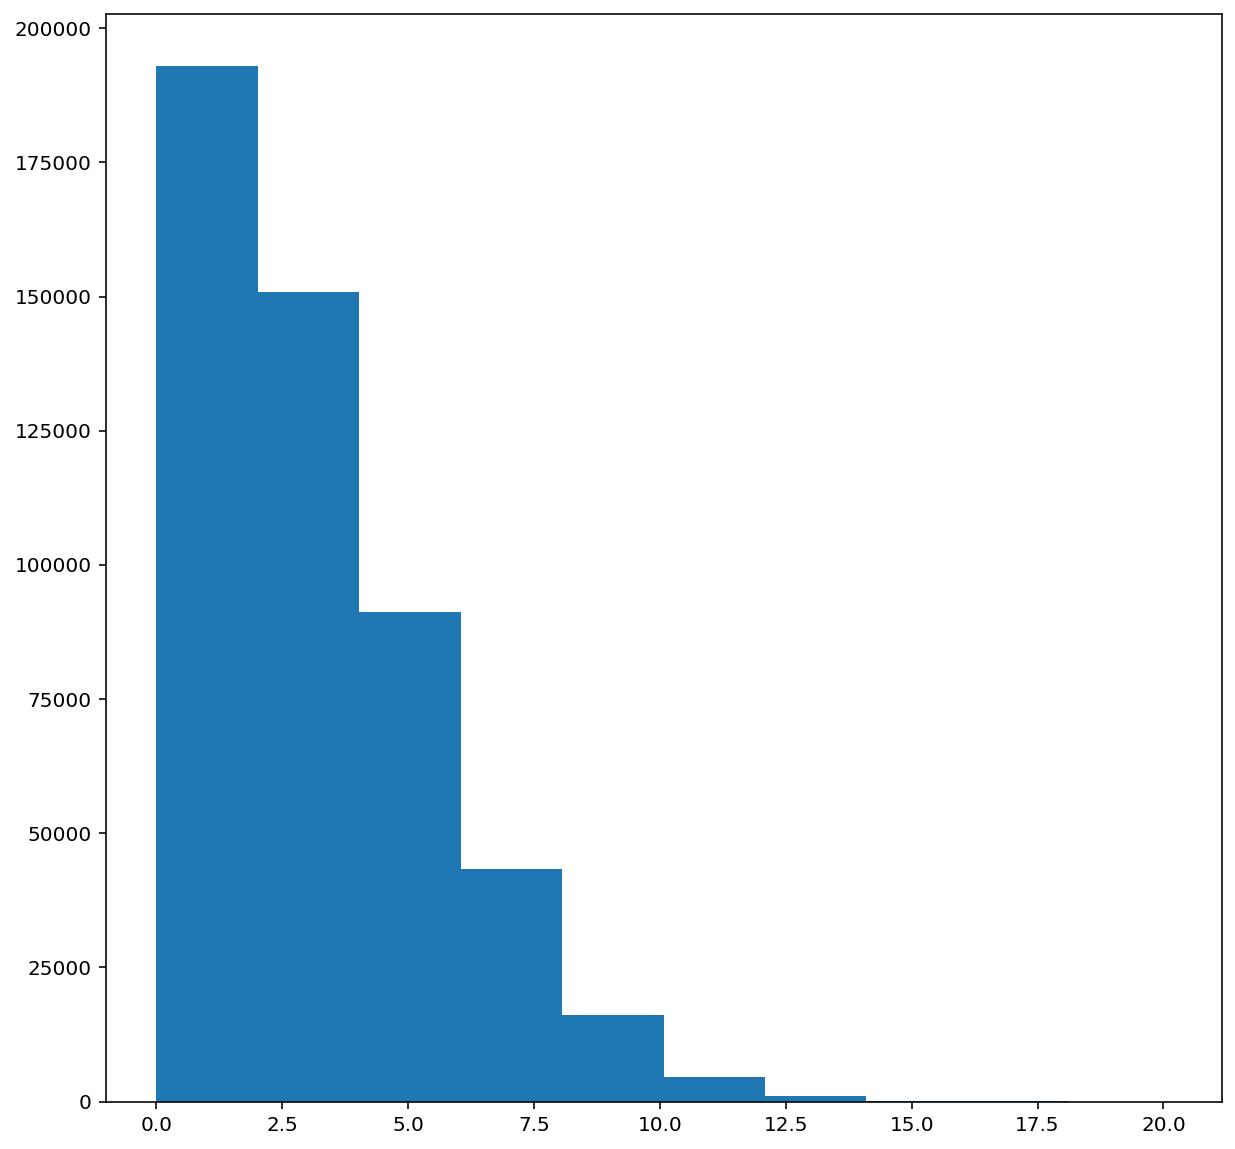

In [170]:
plt.hist(test_pos)

In [171]:
np.mean(test_pos)

3.1885263214469863

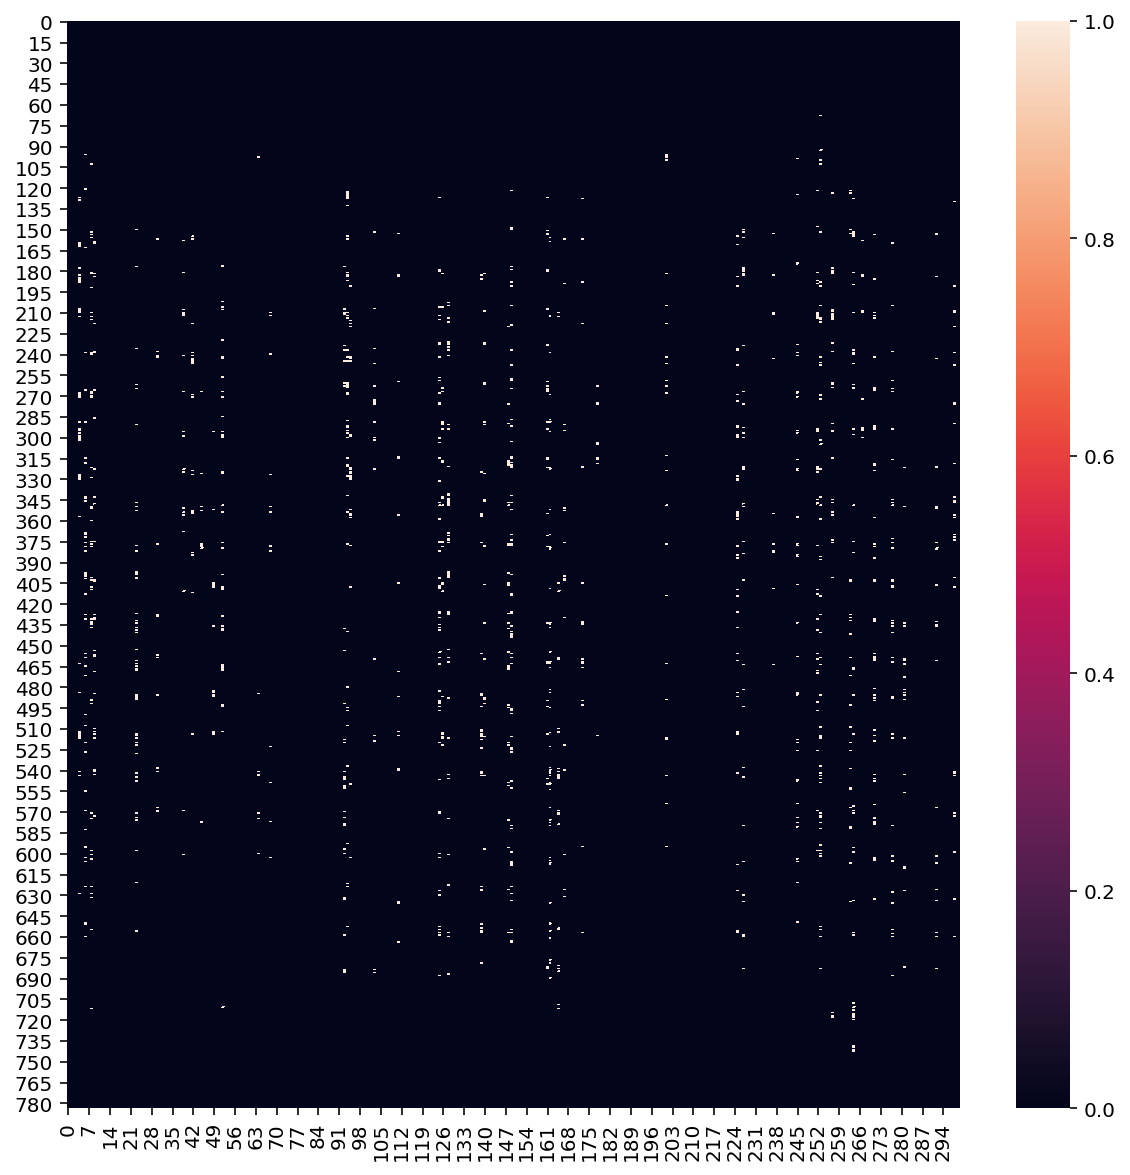

In [175]:
sns.heatmap(fcn_mask.layers[0].bernoulli_mask.numpy())

In [174]:
np.linalg.norm(fcn_mask.layers[0].bernoulli_mask.numpy(), ord=2)

13.717624

In [152]:
MU=0
MU_BI = [-0.13, 0.13]
SIGMA=-1 #0.1 IF SIGMA == -1 --> glorot normal
SIGMA_BI = [-SIGMA, SIGMA]
fcn_mask, initial_weights_mask = init.set_weights_man(fcn_mask, mode="signed_constant", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=True)
fcn_mask, initial_masks = init.set_weights_man(fcn_mask, mode="normal", constant=0, mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=False, set_mask=True)
#fcn, initial_weights = init.set_weights_man(fcn, mode="normal", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="./weights/initial_weights", weight_as_constant=True)

Glorot normal with sigma 0.0018
Glorot normal with sigma 0.0050
Glorot normal with sigma 0.0182


In [416]:
initial_weights[0].shape

(784, 300)

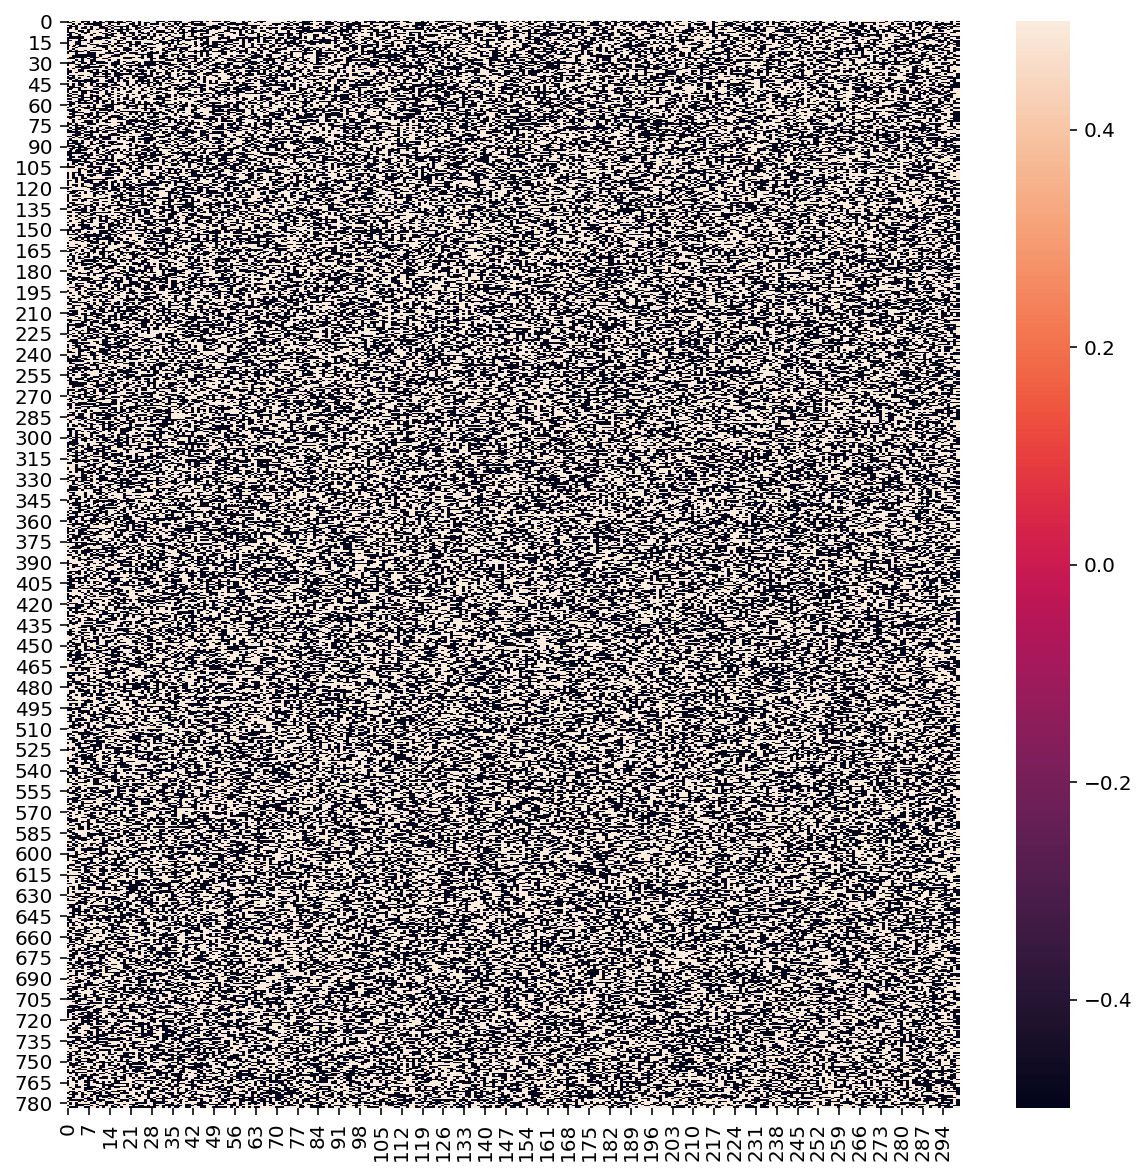

In [141]:
sns.heatmap(fcn_mask.layers[0].get_normal_weights().numpy())

In [417]:
fcn_mask, initial_weights = init.set_weights_man(fcn_mask, mode="signed_constant", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=True)

In [369]:
for i,layer in enumerate(fcn_mask.layers):
    layer.set_normal_weights(fcn.layers[i].get_weights()[0])

In [161]:
MU=0
MU_BI = [-0.13, 0.13]
SIGMA=-1 #0.1 IF SIGMA == -1 --> glorot normal
SIGMA_BI = [-SIGMA, SIGMA]
fcn, initial_weights = init.set_weights_man(fcn, mode="normal", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=True)
fcn, initial_weights = init.set_weights_man(fcn, mode="normal", constant=1, mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=False, set_mask=True)
#fcn, initial_weights = init.set_weights_man(fcn, mode="normal", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="./weights/initial_weights", weight_as_constant=True)

Glorot normal with sigma 0.0018
Glorot normal with sigma 0.0050
Glorot normal with sigma 0.0182
Glorot normal with sigma 0.0018
Glorot normal with sigma 0.0050
Glorot normal with sigma 0.0182


In [35]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
@tf.function
def custom_loss(y, pred, model):
    x_ent = loss_fn(y,pred)
    no_ones_sqrt = sum([np.sum(layer.bernoulli_mask) for layer in model.layers]) ** 0.5
    
    return x_ent + 0.009 * no_ones_sqrt
                      

In [36]:
def get_zero_rows(model):
    rows_to_be_deleted = []
    rows_to_be_kept = []
    for i,layer in enumerate(model.layers):
        #import pdb; pdb.set_trace()
        a = layer.bernoulli_mask.numpy()
        row_delete = np.where(~a.any(axis=1))[0]
        row_keep = np.where(a.any(axis=1))[0]
        rows_to_be_deleted.append(row_delete)
        rows_to_be_kept.append(row_keep)

        col = np.where(~a.any(axis=0))[0]


        print(f"Layer {i}: {row_delete.shape[0]} Rows can be deleted and {col.shape[0]} Columns")

    return rows_to_be_deleted, rows_to_be_kept

def get_pruned_initial_weights(old_initial_weights, rows_to_be_kept, keep_input=True):
    new_initial_weights = []
    for i in range(len(rows_to_be_kept)):
        #print(i,"/",len(rows_to_be_kept))
        if i is 0:
            # do not delete any input neurons, yet
            if keep_input is True:
                #import pdb; pdb.set_trace()
                w = old_initial_weights[i][:, rows_to_be_kept[1]]
                #w = old_initial_weights[i][0][:, rows_to_be_kept[1]]
            else:
                w = old_initial_weights[i][rows_to_be_kept[i][:,None],rows_to_be_kept[i+1]]
                #w = old_initial_weights[i][0][rows_to_be_kept[i][:,None],rows_to_be_kept[i+1]]
            #b = old_initial_weights[i][1][:rows_to_be_kept[i+1].shape[0]]
        elif i is len(rows_to_be_kept)-1:
            w = old_initial_weights[i][rows_to_be_kept[i],:]
            #w = old_initial_weights[i][0][rows_to_be_kept[i],:]
            #b = old_initial_weights[i][1]
        else:
            w = old_initial_weights[i][rows_to_be_kept[i][:,None],rows_to_be_kept[i+1]]
            #w = old_initial_weights[i][0][rows_to_be_kept[i][:,None],rows_to_be_kept[i+1]]
            #b = old_initial_weights[i][1][:rows_to_be_kept[i+1].shape[0]]


        #wb = [w,b]
        new_initial_weights.append(w)
        #new_initial_weights.append(wb)
        
    #import pdb; pdb.set_trace()

    return new_initial_weights

def get_new_shape(input_dim, rows_to_be_kept, keep_input=True):
    new_shape = []
    for i in range(len(rows_to_be_kept)):
        if i == 0:
            if keep_input is True:
                tmp = [input_dim, rows_to_be_kept[1].shape[0]]
            else:
                tmp = [rows_to_be_kept[i].shape[0], rows_to_be_kept[i+1].shape[0]]
        elif i == len(rows_to_be_kept)-1:
            tmp = [rows_to_be_kept[i].shape[0], 10]
        else:
            tmp = [rows_to_be_kept[i].shape[0], rows_to_be_kept[i+1].shape[0]]
        new_shape.append(tmp)
    return new_shape

In [37]:
from copy import copy

# Try to exclude rows/cols that are all zero from trainable weights

In [146]:
def train_supermask_model(model, ds_train, epochs=6, prune_neurons=False, keep_input=True):
    
    lr = 170
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)#tf.keras.optimizers.SGD(learning_rate=190, momentum=0.9) , momentum=0.9, nesterov=True
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    loss_metric = tf.keras.metrics.Mean()
    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    
    loss_history = []
    acc_history = []
    
    #input_dim = model.layers[0].shape[0]
    
    #new_initial_weights = [layer.get_normal_weights().numpy() for layer in model.layers]
    
    #new_initial_masks = [layer.mask.numpy() for layer in model.layers]
    
    #all_trainable_vars_original = tf.reduce_sum([tf.reduce_prod(v.shape) for v in model.trainable_variables]).numpy()
    
    #smaller_model = copy(model)
    
    for epoch in range(epochs):
        
        #for i,layer in enumerate(model.layers):
        #    print(f"Layer {i} multiplier: {layer.multiplier:.4f}")
        
        #if epoch == 140:
            #optimizer = tf.keras.optimizers.SGD(learning_rate=70, momentum=0.9)
    
        #print(f"Start of epoch {epoch+1}")

        # Iterate over the batches of the dataset.
        for step, (x_batch_train,y_batch_train) in enumerate(ds_train):
            with tf.GradientTape() as tape:
                predicted = model(x_batch_train)
                # Compute reconstruction loss
                loss = loss_fn(y_batch_train, predicted)
                #loss = custom_loss(y_batch_train, predicted, model)


            grads = tape.gradient(loss, model.trainable_weights)
            #print(f"Gradient value mean: {tf.math.reduce_mean(grads[0]).numpy()}")
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            loss_metric(loss)

            acc_metric(y_batch_train,predicted)
            
        print(f"End of Epoch: {epoch+1}: Accuracy = {acc_metric.result().numpy():.6f} --- Mean Loss = {loss_metric.result().numpy():.6f}")
        
        loss_history.append(loss_metric.result().numpy())
        acc_history.append(acc_metric.result().numpy())
        
        
        global_no_ones = np.sum([np.sum(layer.bernoulli_mask) for layer in fcn_mask.layers])
        global_size = np.sum([tf.size(layer.bernoulli_mask) for layer in fcn_mask.layers])
        
        print(f"{(global_no_ones/global_size)*100:.2f}% of weights are 'remaining'")

    return model, loss_history, acc_history

In [153]:
fcn_mask, loss_history_mask, acc_history_mask = train_supermask_model(fcn_mask, ds_train_mnist, epochs=80)

End of Epoch: 1: Accuracy = 0.782717 --- Mean Loss = 0.729341
1.40% of weights are 'remaining'
End of Epoch: 2: Accuracy = 0.842258 --- Mean Loss = 0.545751
1.19% of weights are 'remaining'
End of Epoch: 3: Accuracy = 0.865394 --- Mean Loss = 0.473081
1.09% of weights are 'remaining'
End of Epoch: 4: Accuracy = 0.877796 --- Mean Loss = 0.432457
1.03% of weights are 'remaining'
End of Epoch: 5: Accuracy = 0.886243 --- Mean Loss = 0.405649
0.98% of weights are 'remaining'
End of Epoch: 6: Accuracy = 0.891664 --- Mean Loss = 0.387050
0.93% of weights are 'remaining'
End of Epoch: 7: Accuracy = 0.896186 --- Mean Loss = 0.372174
0.91% of weights are 'remaining'
End of Epoch: 8: Accuracy = 0.899885 --- Mean Loss = 0.360153
0.89% of weights are 'remaining'
End of Epoch: 9: Accuracy = 0.902919 --- Mean Loss = 0.350082
0.87% of weights are 'remaining'
End of Epoch: 10: Accuracy = 0.905488 --- Mean Loss = 0.341743
0.85% of weights are 'remaining'
End of Epoch: 11: Accuracy = 0.907661 --- Mean Lo

In [116]:
masks_trained_weights = [layer.bernoulli_mask for layer in fcn_mask.layers]

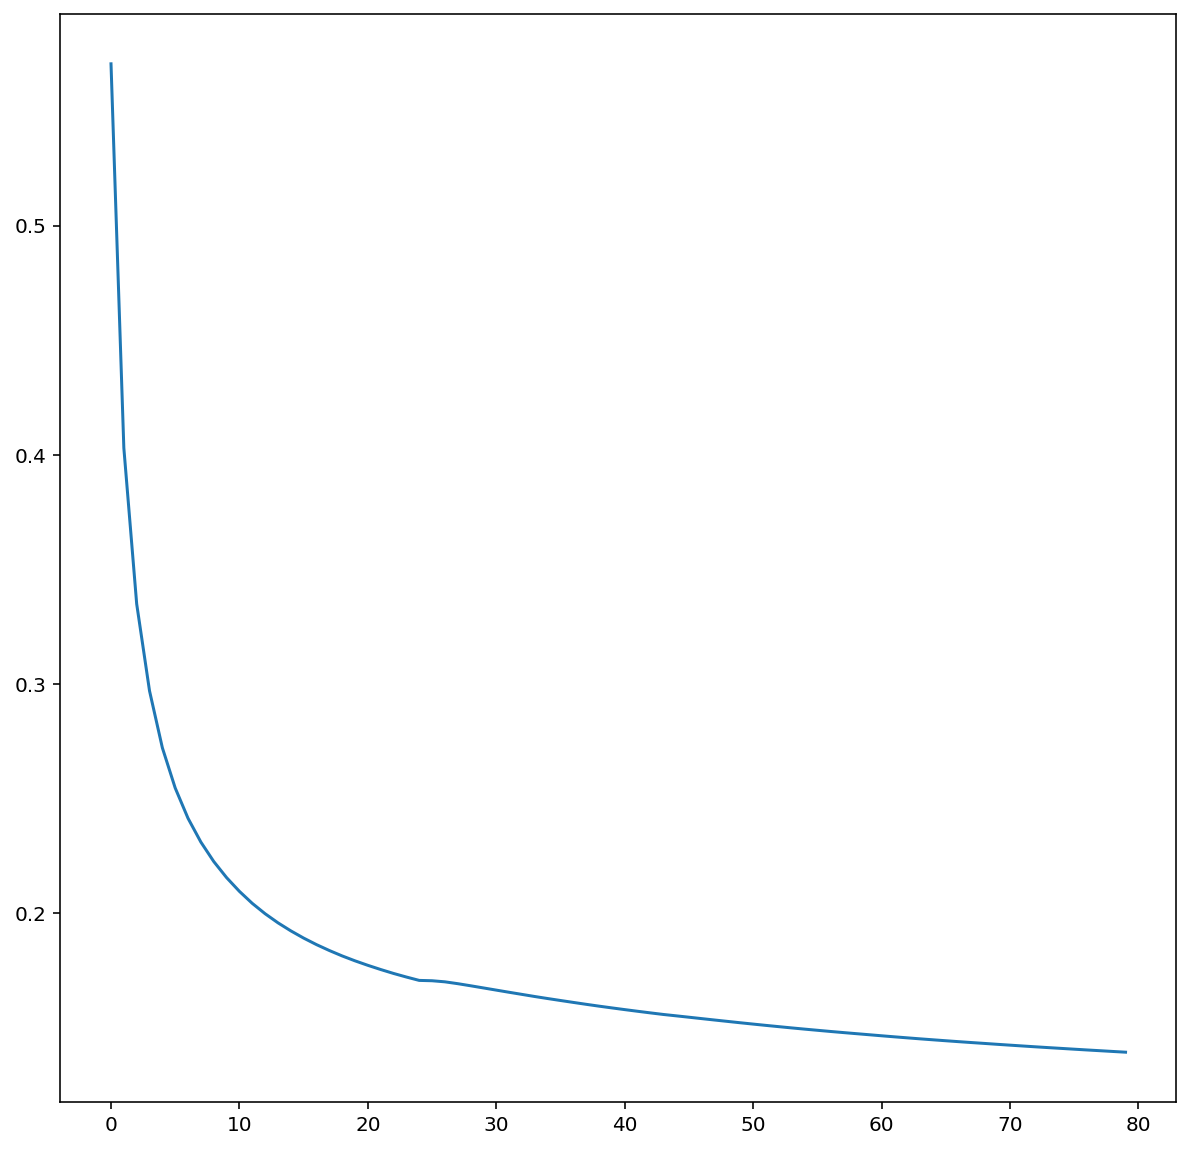

In [122]:
plt.plot(loss_history_mask)

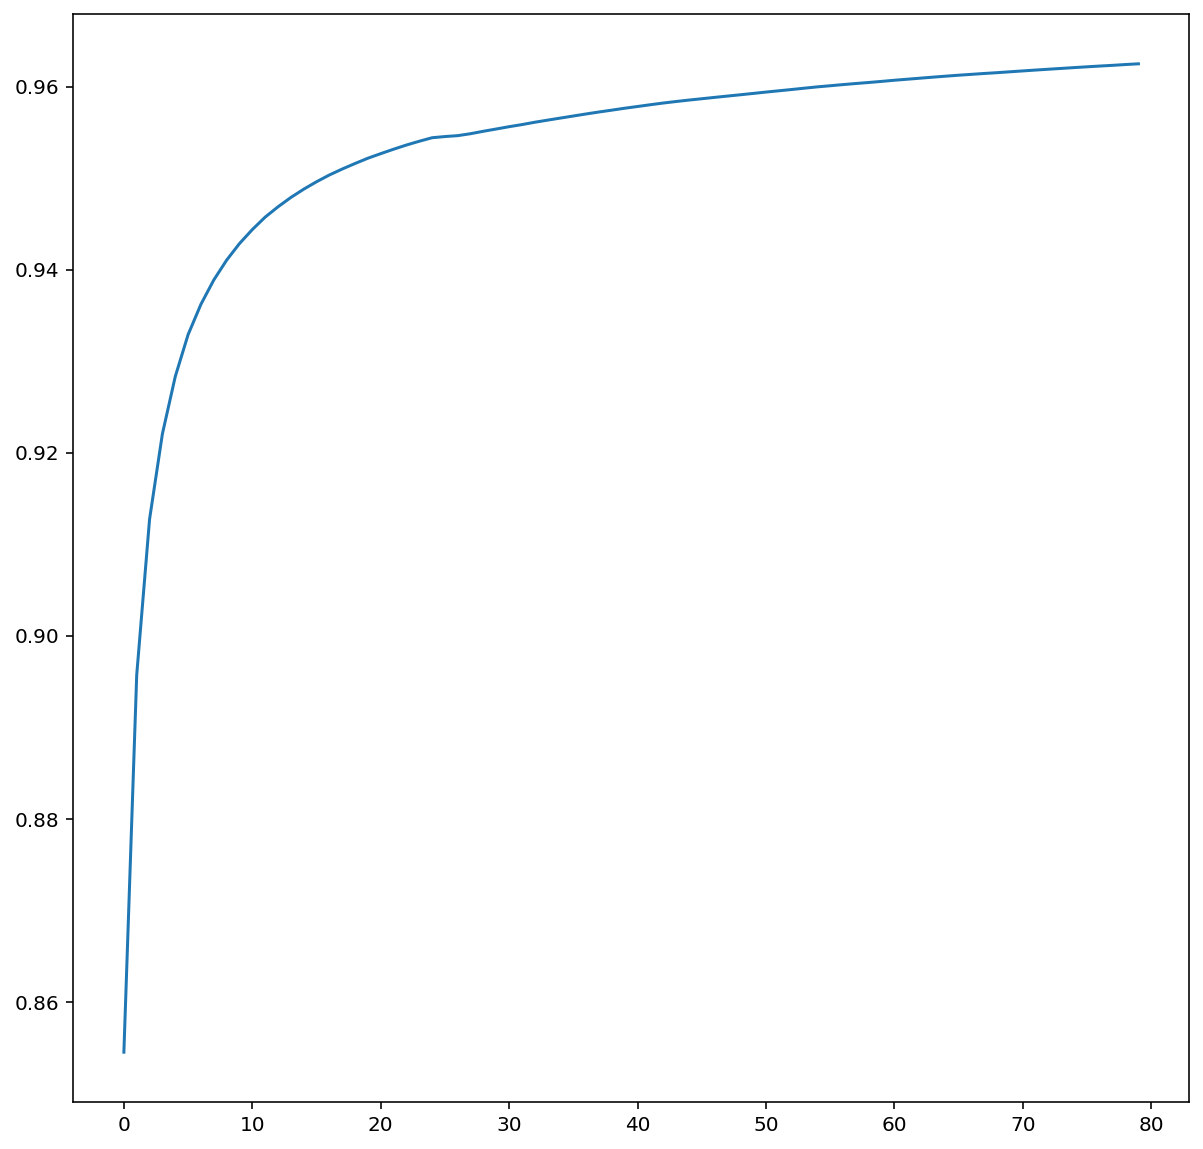

In [123]:
plt.plot(acc_history_mask)

In [106]:
global_no_ones = np.sum([np.sum(layer.bernoulli_mask) for layer in fcn_mask.layers])
global_size = np.sum([tf.size(layer.bernoulli_mask) for layer in fcn_mask.layers])

In [107]:
global_no_ones / global_size

0.31413974455296767

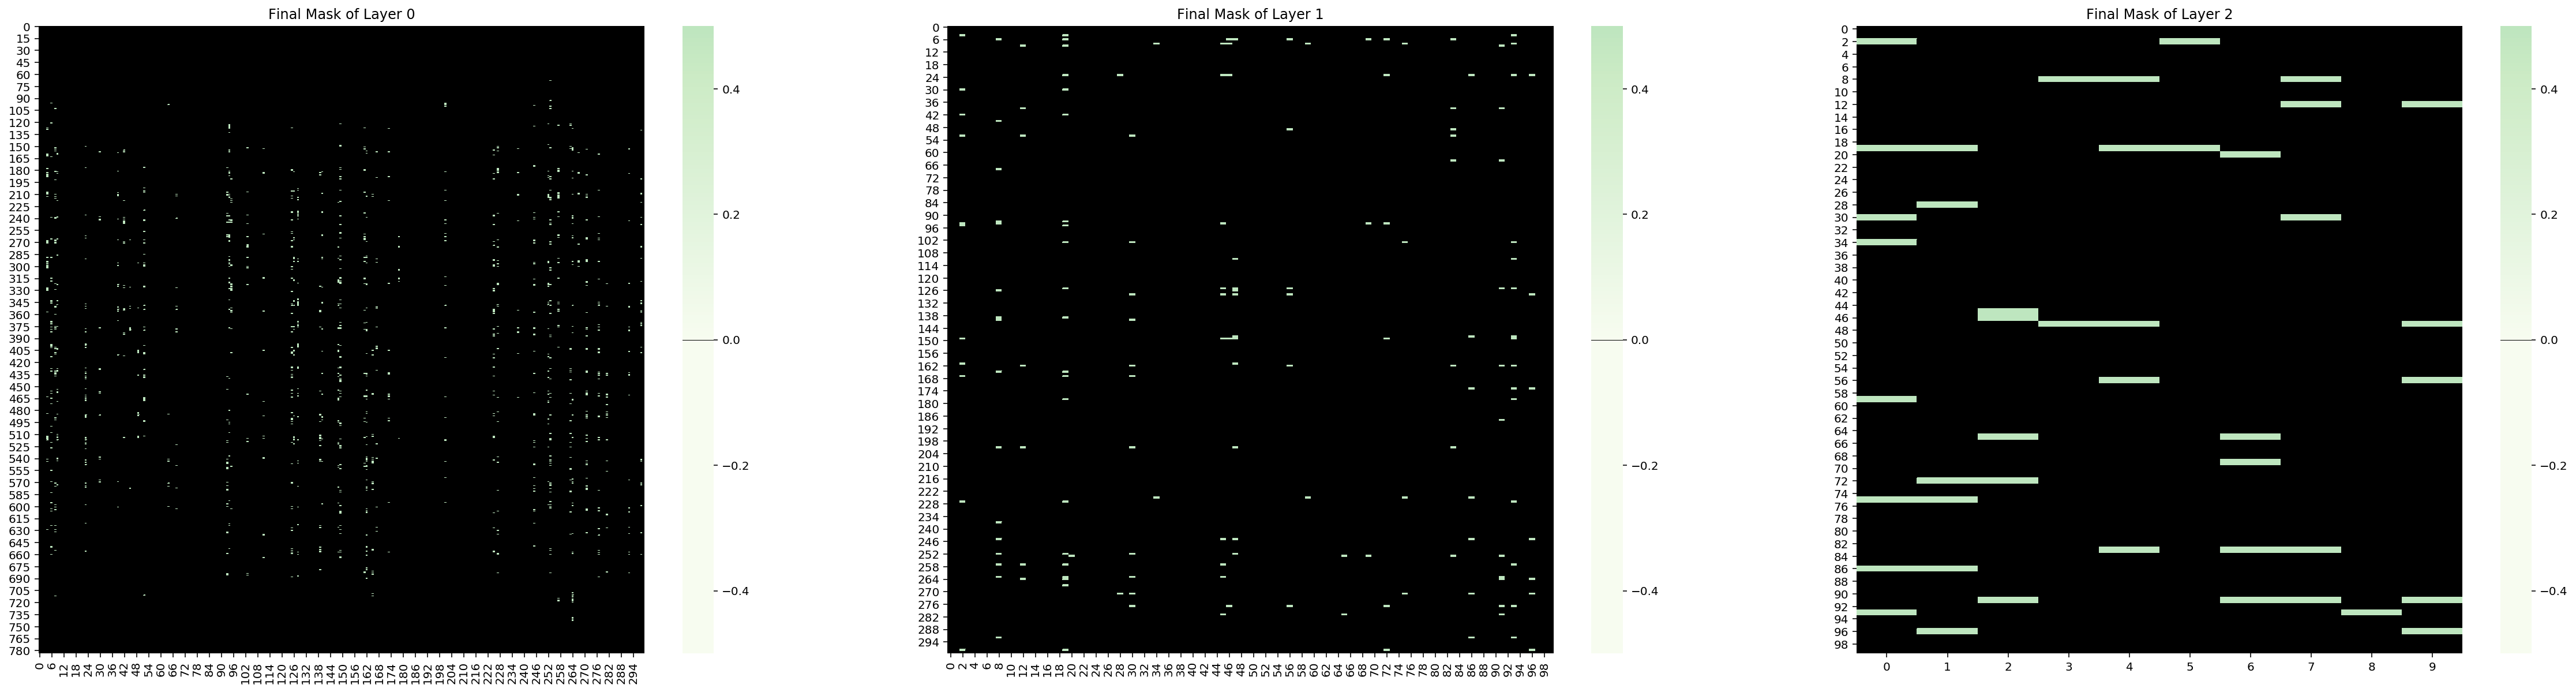

In [154]:
plt.figure(figsize=(40,10))
for layer in range(len(fcn_mask.trainable_weights)):
    plt.subplot(1,len(fcn_mask.trainable_weights),layer+1)
    mask = fcn_mask.layers[layer].bernoulli_mask.numpy()
    _ = sns.heatmap(mask, cbar=True, cmap=cmap, vmin=-0.5, vmax=0.5)
    plt.title(f"Final Mask of Layer {layer}")
#plt.savefig("./img/final_mask_delta_high_same_sign.png", dpi=1000, bbox_inches="tight")

In [155]:
for layer in fcn_mask.layers:
    print(layer.multiplier)

tf.Tensor(162.99376, shape=(), dtype=float32)
tf.Tensor(178.57143, shape=(), dtype=float32)
tf.Tensor(22.727272, shape=(), dtype=float32)


In [112]:
just_eval(fcn_mask, ds_test_mnist)

Evaluation Loss: 0.2379157692193985
Evaluation Accuracy: 0.9771999716758728


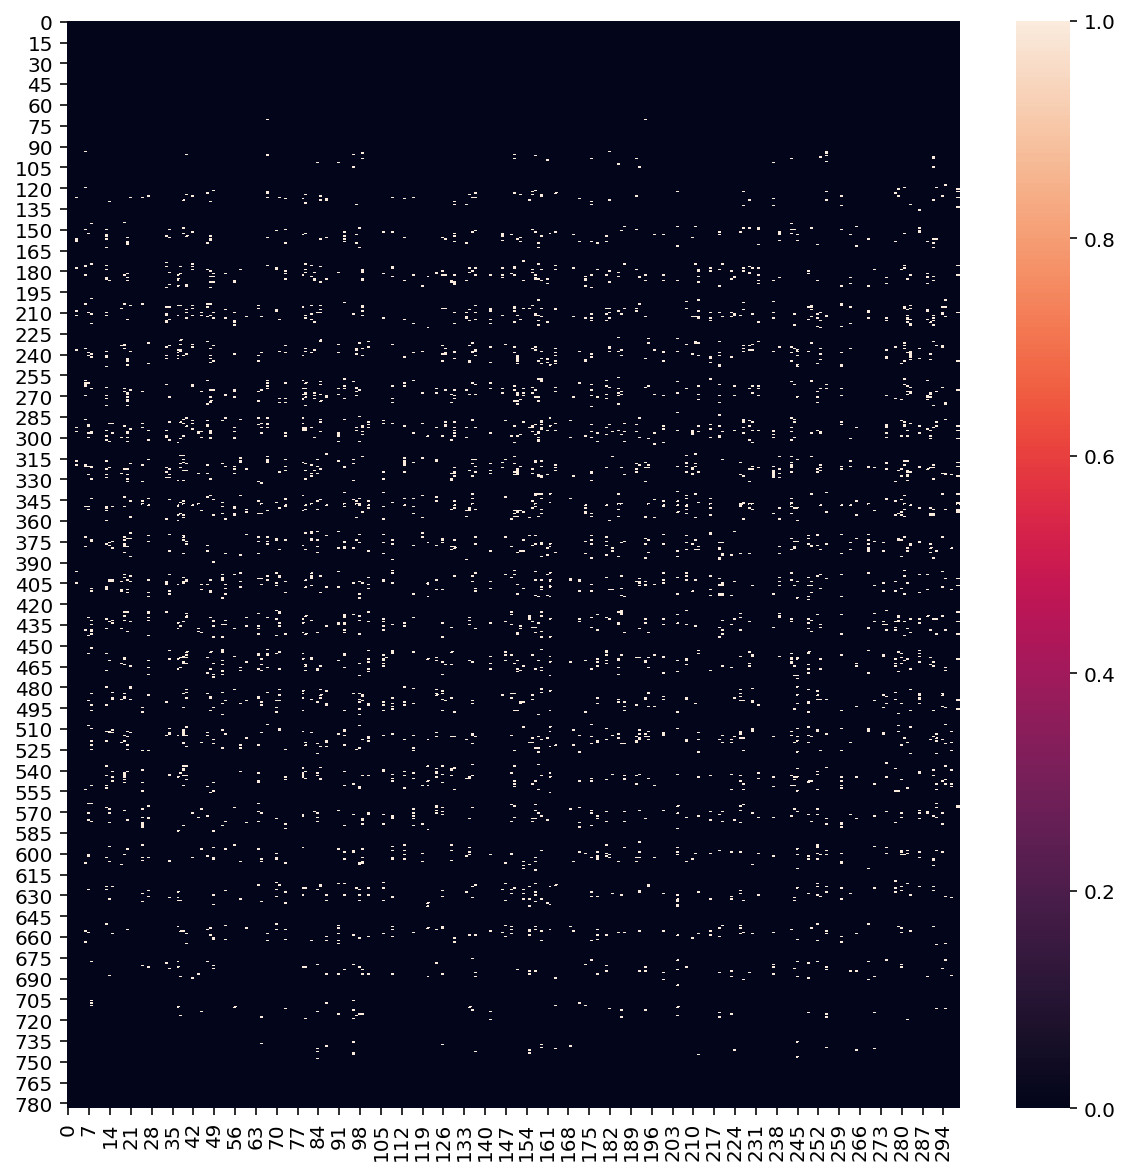

In [406]:
sns.heatmap(fcn_mask.layers[0].bernoulli_mask.numpy())

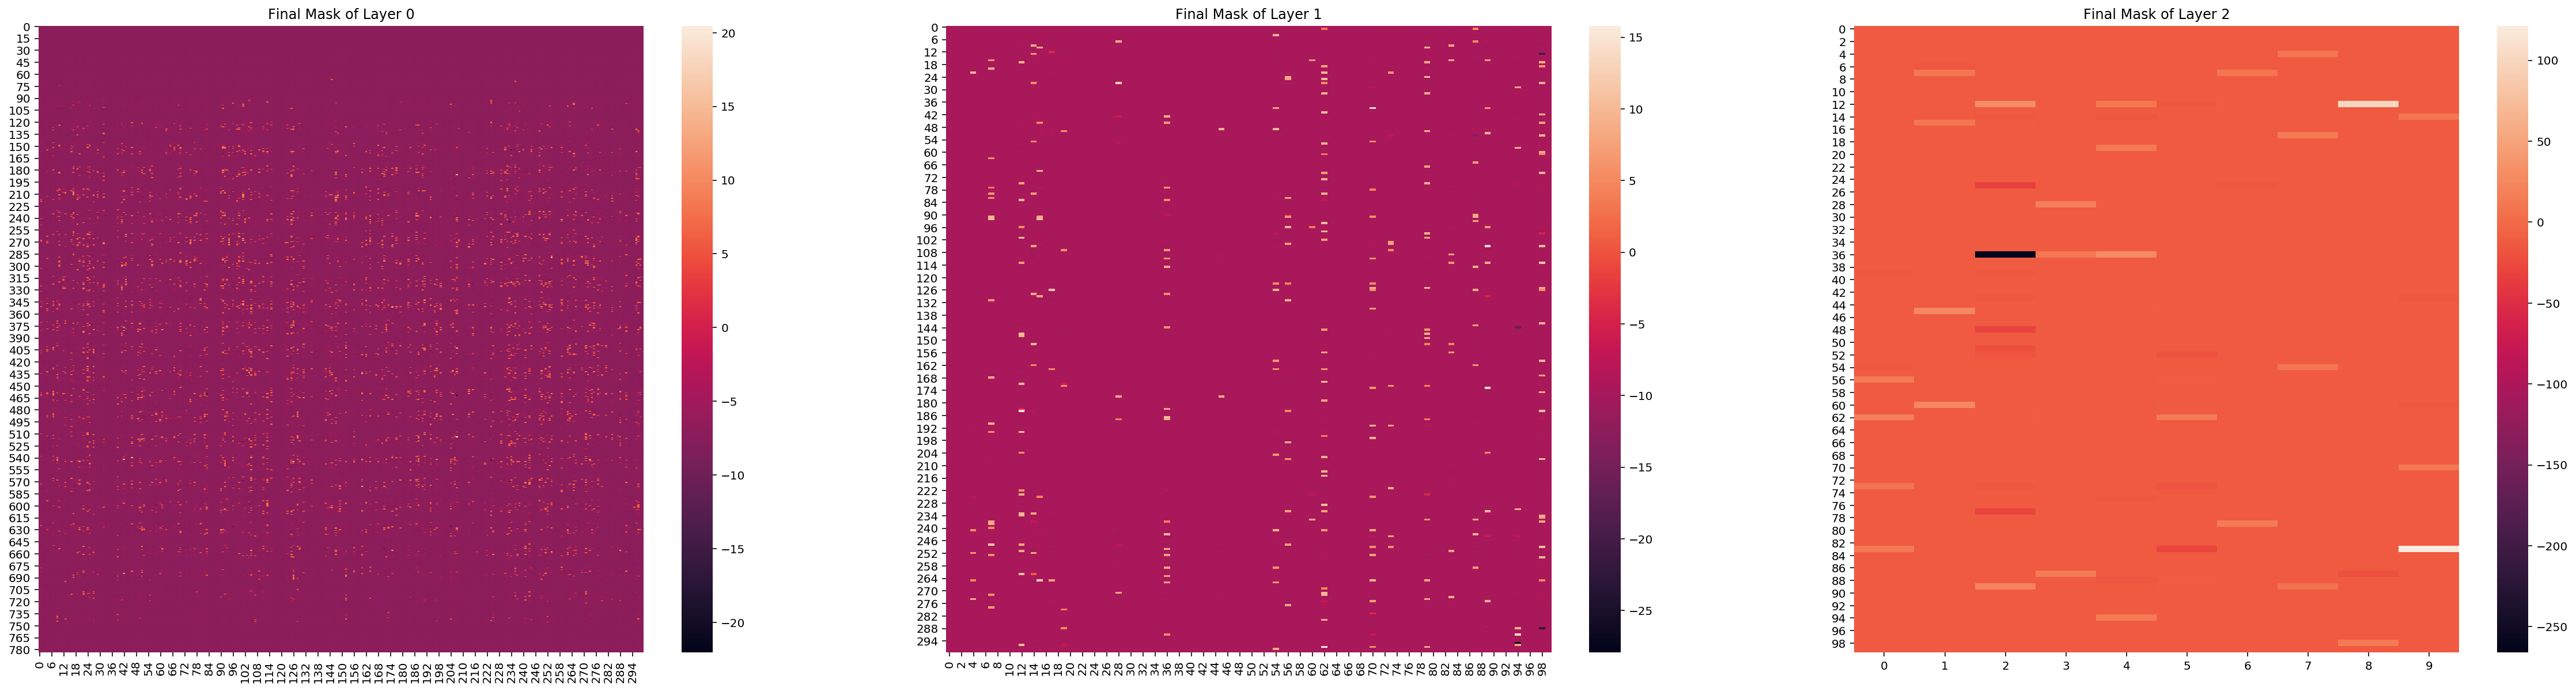

In [125]:
plt.figure(figsize=(40,10))
for layer in range(len(fcn_mask.trainable_weights)):
    plt.subplot(1,len(fcn_mask.trainable_weights),layer+1)
    mask = fcn_mask.layers[layer].mask.numpy()
    _ = sns.heatmap(mask, cbar=True)
    plt.title(f"Final Mask of Layer {layer}")
#sns.heatmap(fcn_mask.layers[0].mask.numpy())

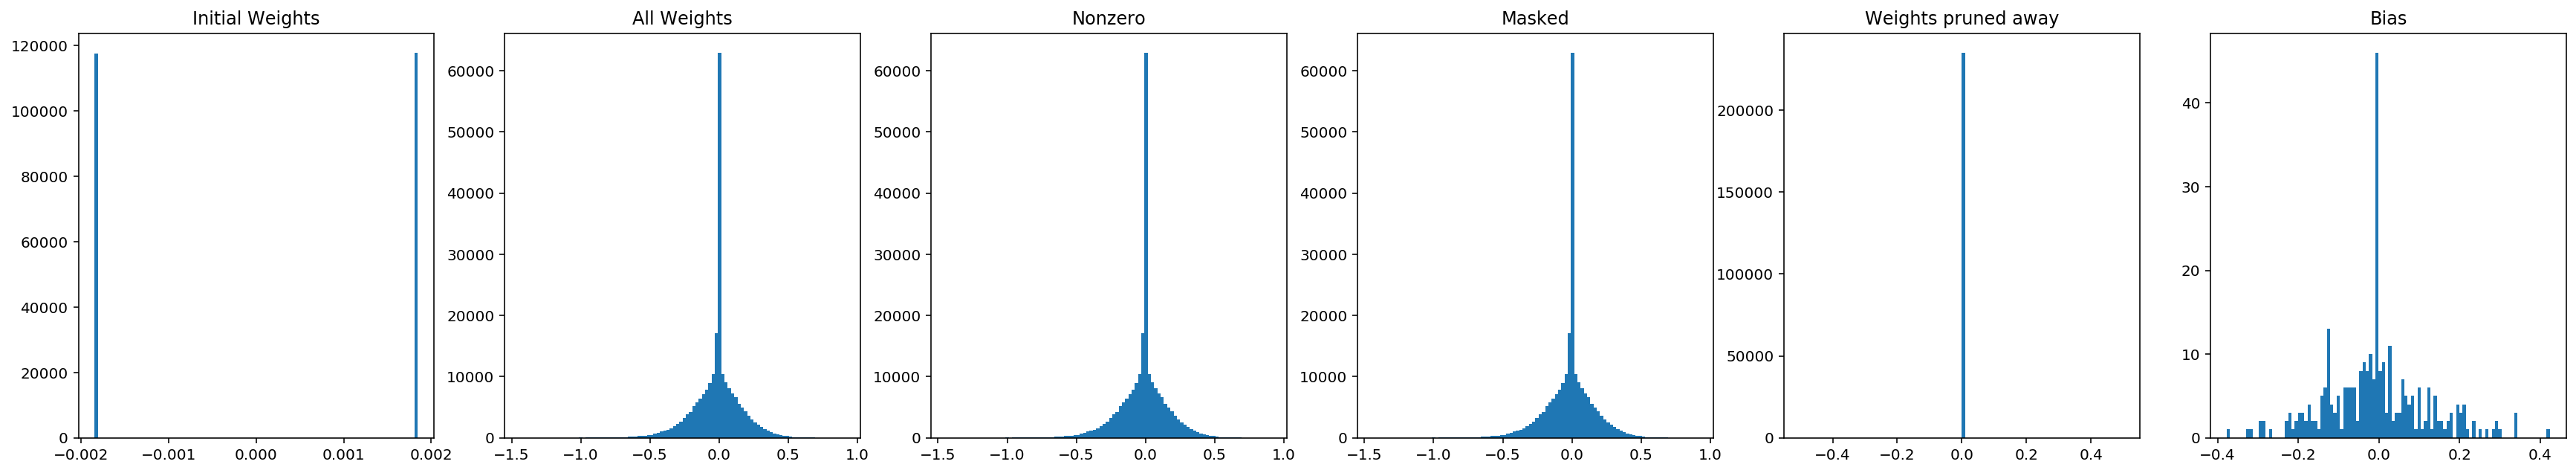

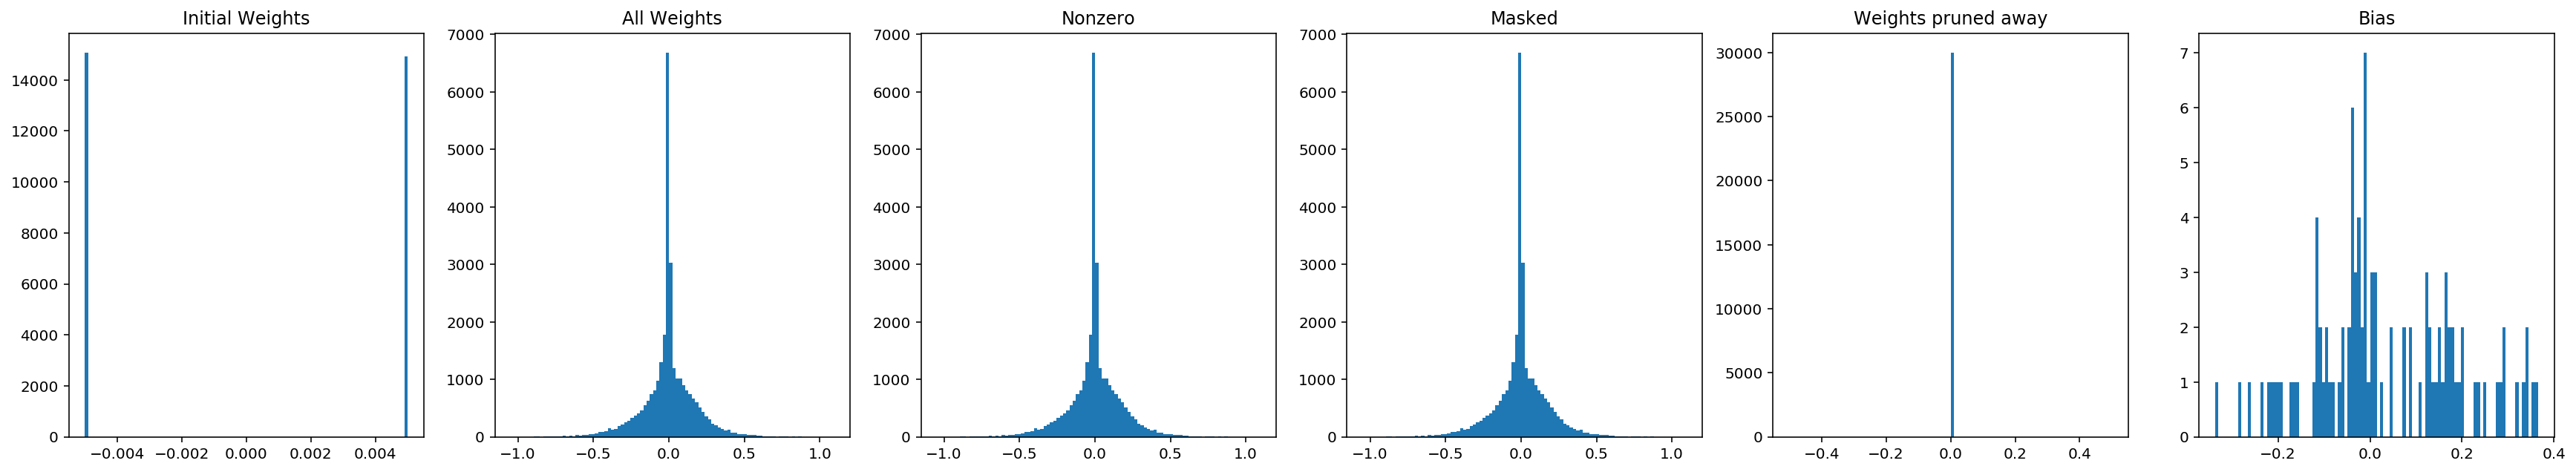

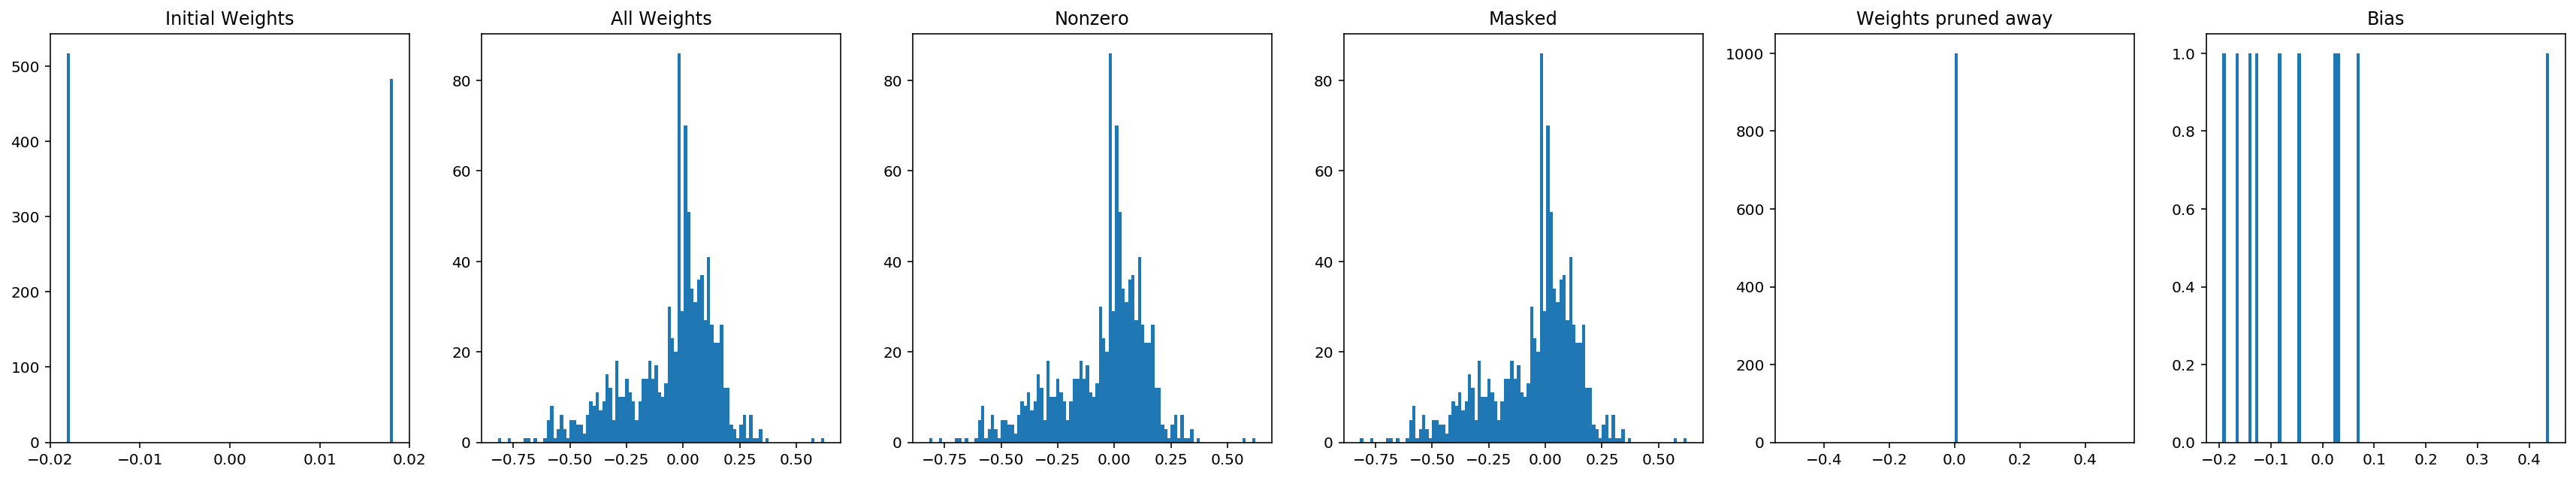

In [129]:
for i, layer in enumerate(fcn.layers):
    plt.figure(figsize=(30,5))
    plt.subplot(1,6,1)
    plt.title("Initial Weights")
    _ = plt.hist(initial_weights[i][0].flatten(), bins=100)
    plt.subplot(1,6,2)
    plt.title("All Weights")
    _ = plt.hist(layer.get_weights()[0].flatten(), bins=100)
    plt.subplot(1,6,3)
    plt.title("Nonzero")
    _ = plt.hist(layer.get_nonzero_weights().numpy().flatten(), bins=100)
    plt.subplot(1,6,4)
    plt.title("Masked")
    _ = plt.hist(layer.get_masked_weights().numpy().flatten(), bins=100)
    plt.subplot(1,6,5)
    plt.title("Weights pruned away")
    pruned_away = layer.get_pruned_weights().numpy().flatten()
    pruned_away_nonzero = pruned_away[np.nonzero(pruned_away)]
    _ = plt.hist(pruned_away_nonzero, bins=100)
    plt.subplot(1,6,6)
    plt.title("Bias")
    _ = plt.hist(layer.get_bias().numpy().flatten(), bins=100)

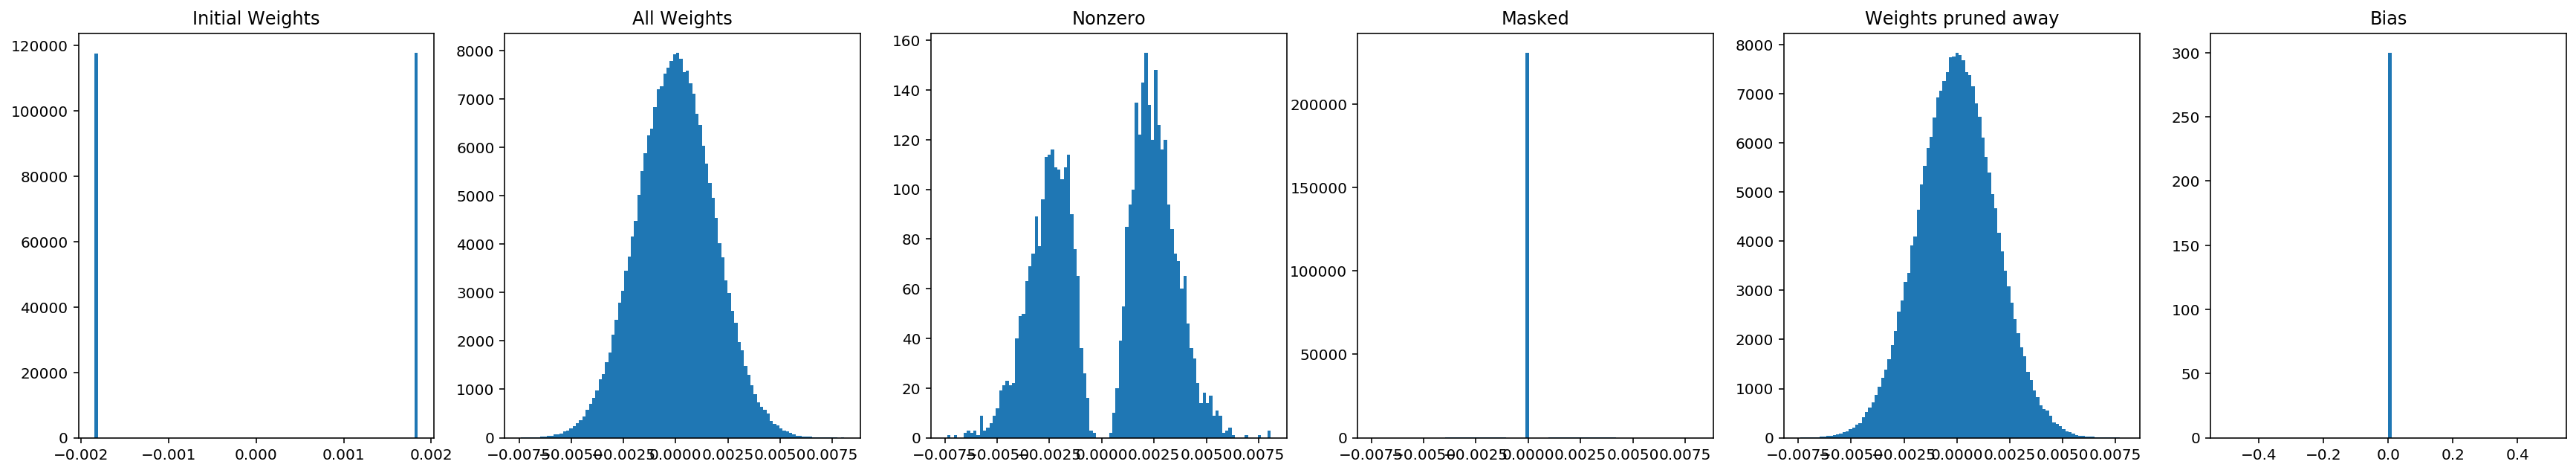

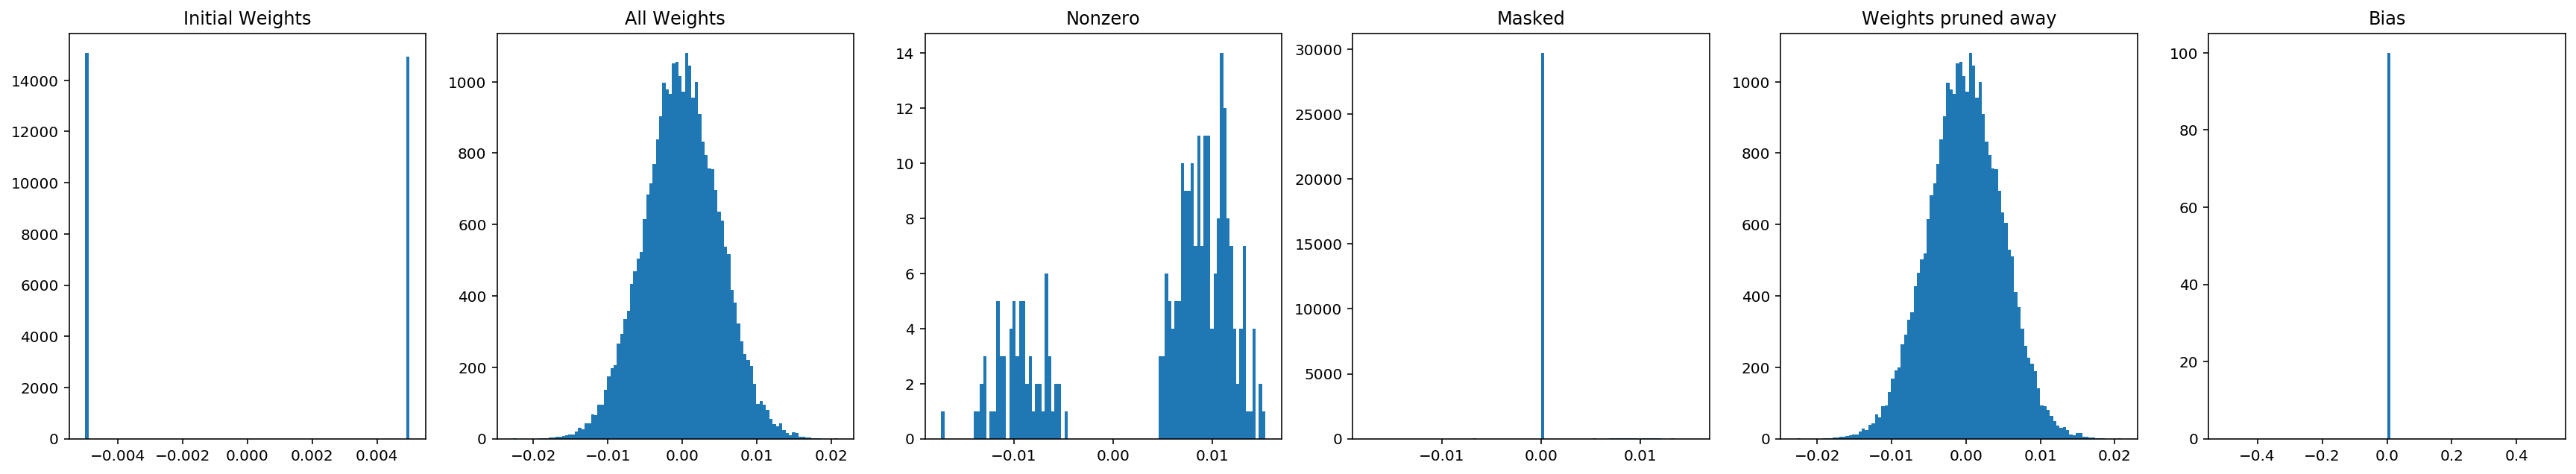

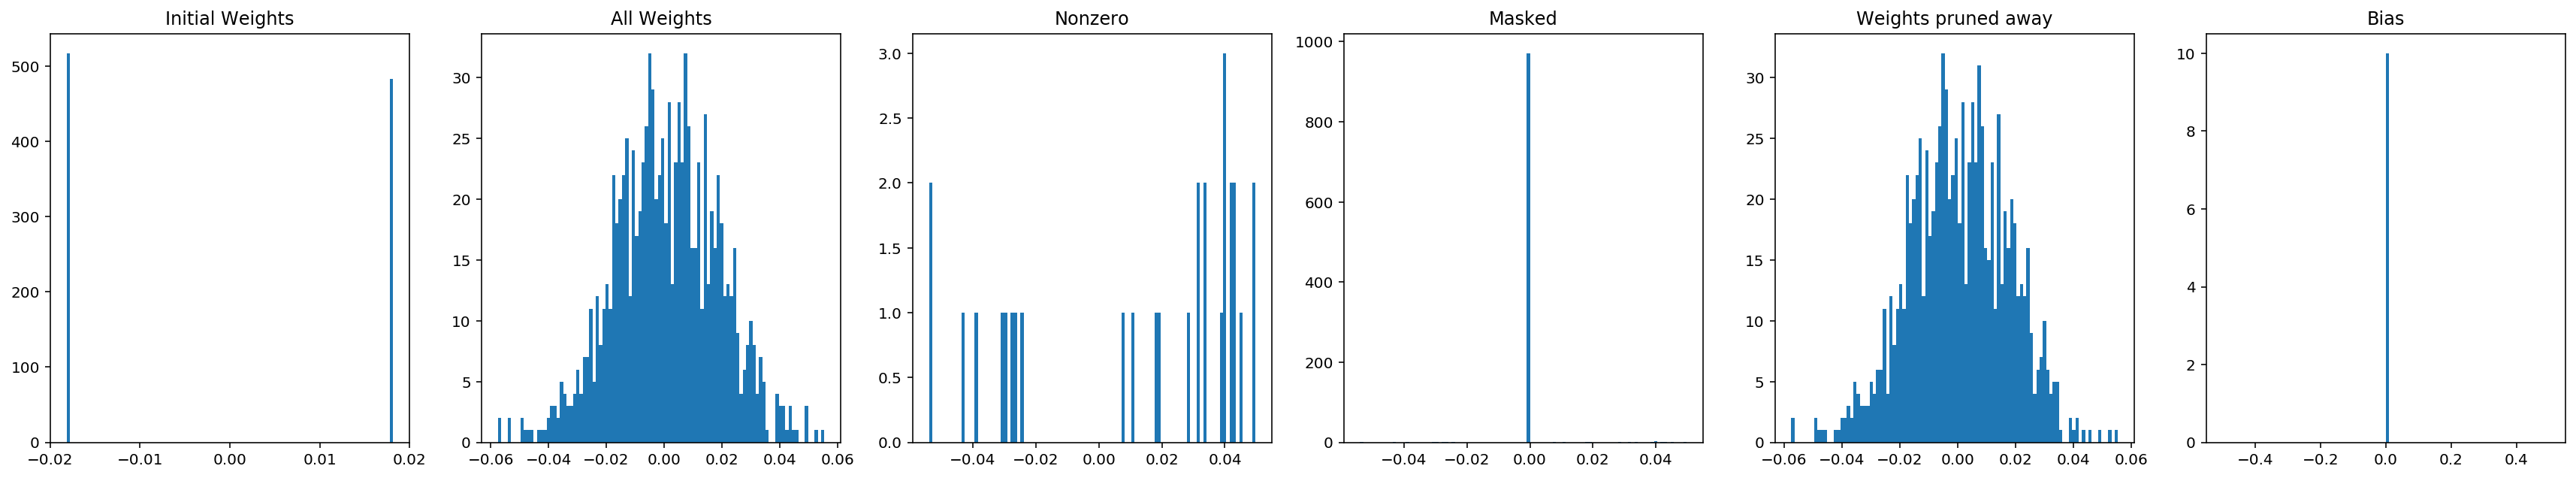

In [130]:
for i, layer in enumerate(fcn_mask.layers):
    plt.figure(figsize=(30,5))
    plt.subplot(1,6,1)
    plt.title("Initial Weights")
    _ = plt.hist(initial_weights[i][0].flatten(), bins=100)
    plt.subplot(1,6,2)
    plt.title("All Weights")
    _ = plt.hist(layer.get_normal_weights().numpy().flatten(), bins=100)
    plt.subplot(1,6,3)
    plt.title("Nonzero")
    _ = plt.hist(layer.get_nonzero_weights().numpy().flatten(), bins=100)
    plt.subplot(1,6,4)
    plt.title("Masked")
    _ = plt.hist(layer.get_masked_weights().numpy().flatten(), bins=100)
    plt.subplot(1,6,5)
    plt.title("Weights pruned away")
    pruned_away = layer.get_pruned_weights().numpy().flatten()
    pruned_away_nonzero = pruned_away[np.nonzero(pruned_away)]
    _ = plt.hist(pruned_away_nonzero, bins=100)
    plt.subplot(1,6,6)
    plt.title("Bias")
    _ = plt.hist(layer.get_bias().numpy().flatten(), bins=100)